In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv('Crop_recommendation.csv')
df.head()

N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

In [3]:
df.shape

(2200, 8)

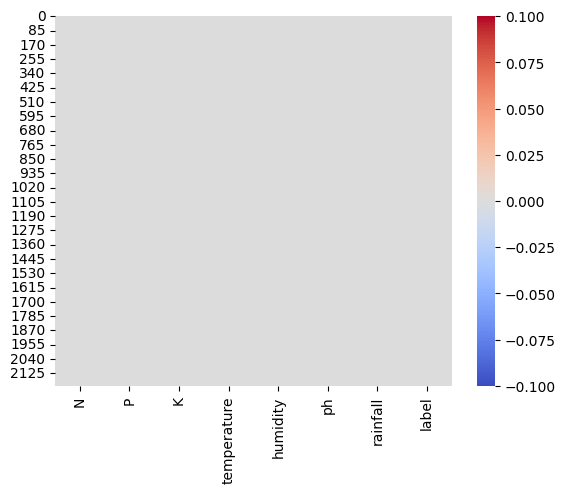

In [4]:
sns.heatmap(df.isnull(),cmap="coolwarm")
plt.show()

<Axes: xlabel='ph', ylabel='Density'>

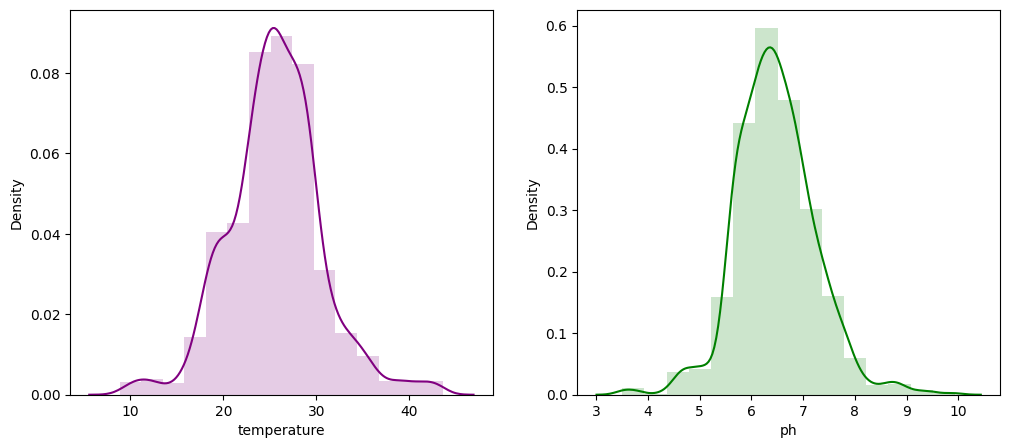

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
# sns.distplot(df_setosa['sepal_length'],kde=True,color='green',bins=20,hist_kws={'alpha':0.3})
sns.distplot(df['temperature'],color="purple",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 2, 2)
sns.distplot(df['ph'],color="green",bins=15,hist_kws={'alpha':0.2})

<Axes: xlabel='count', ylabel='label'>

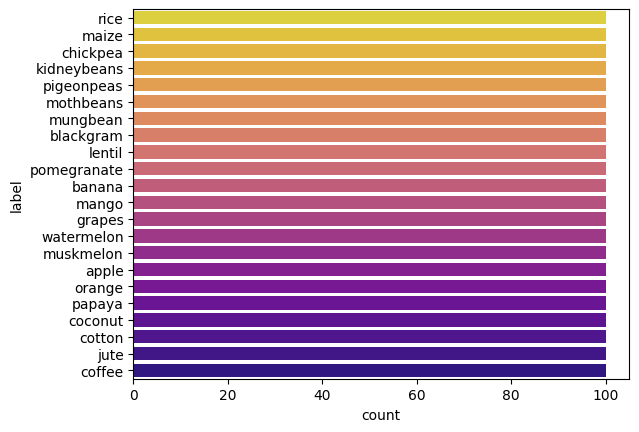

In [6]:
sns.countplot(y='label',data=df, palette="plasma_r")

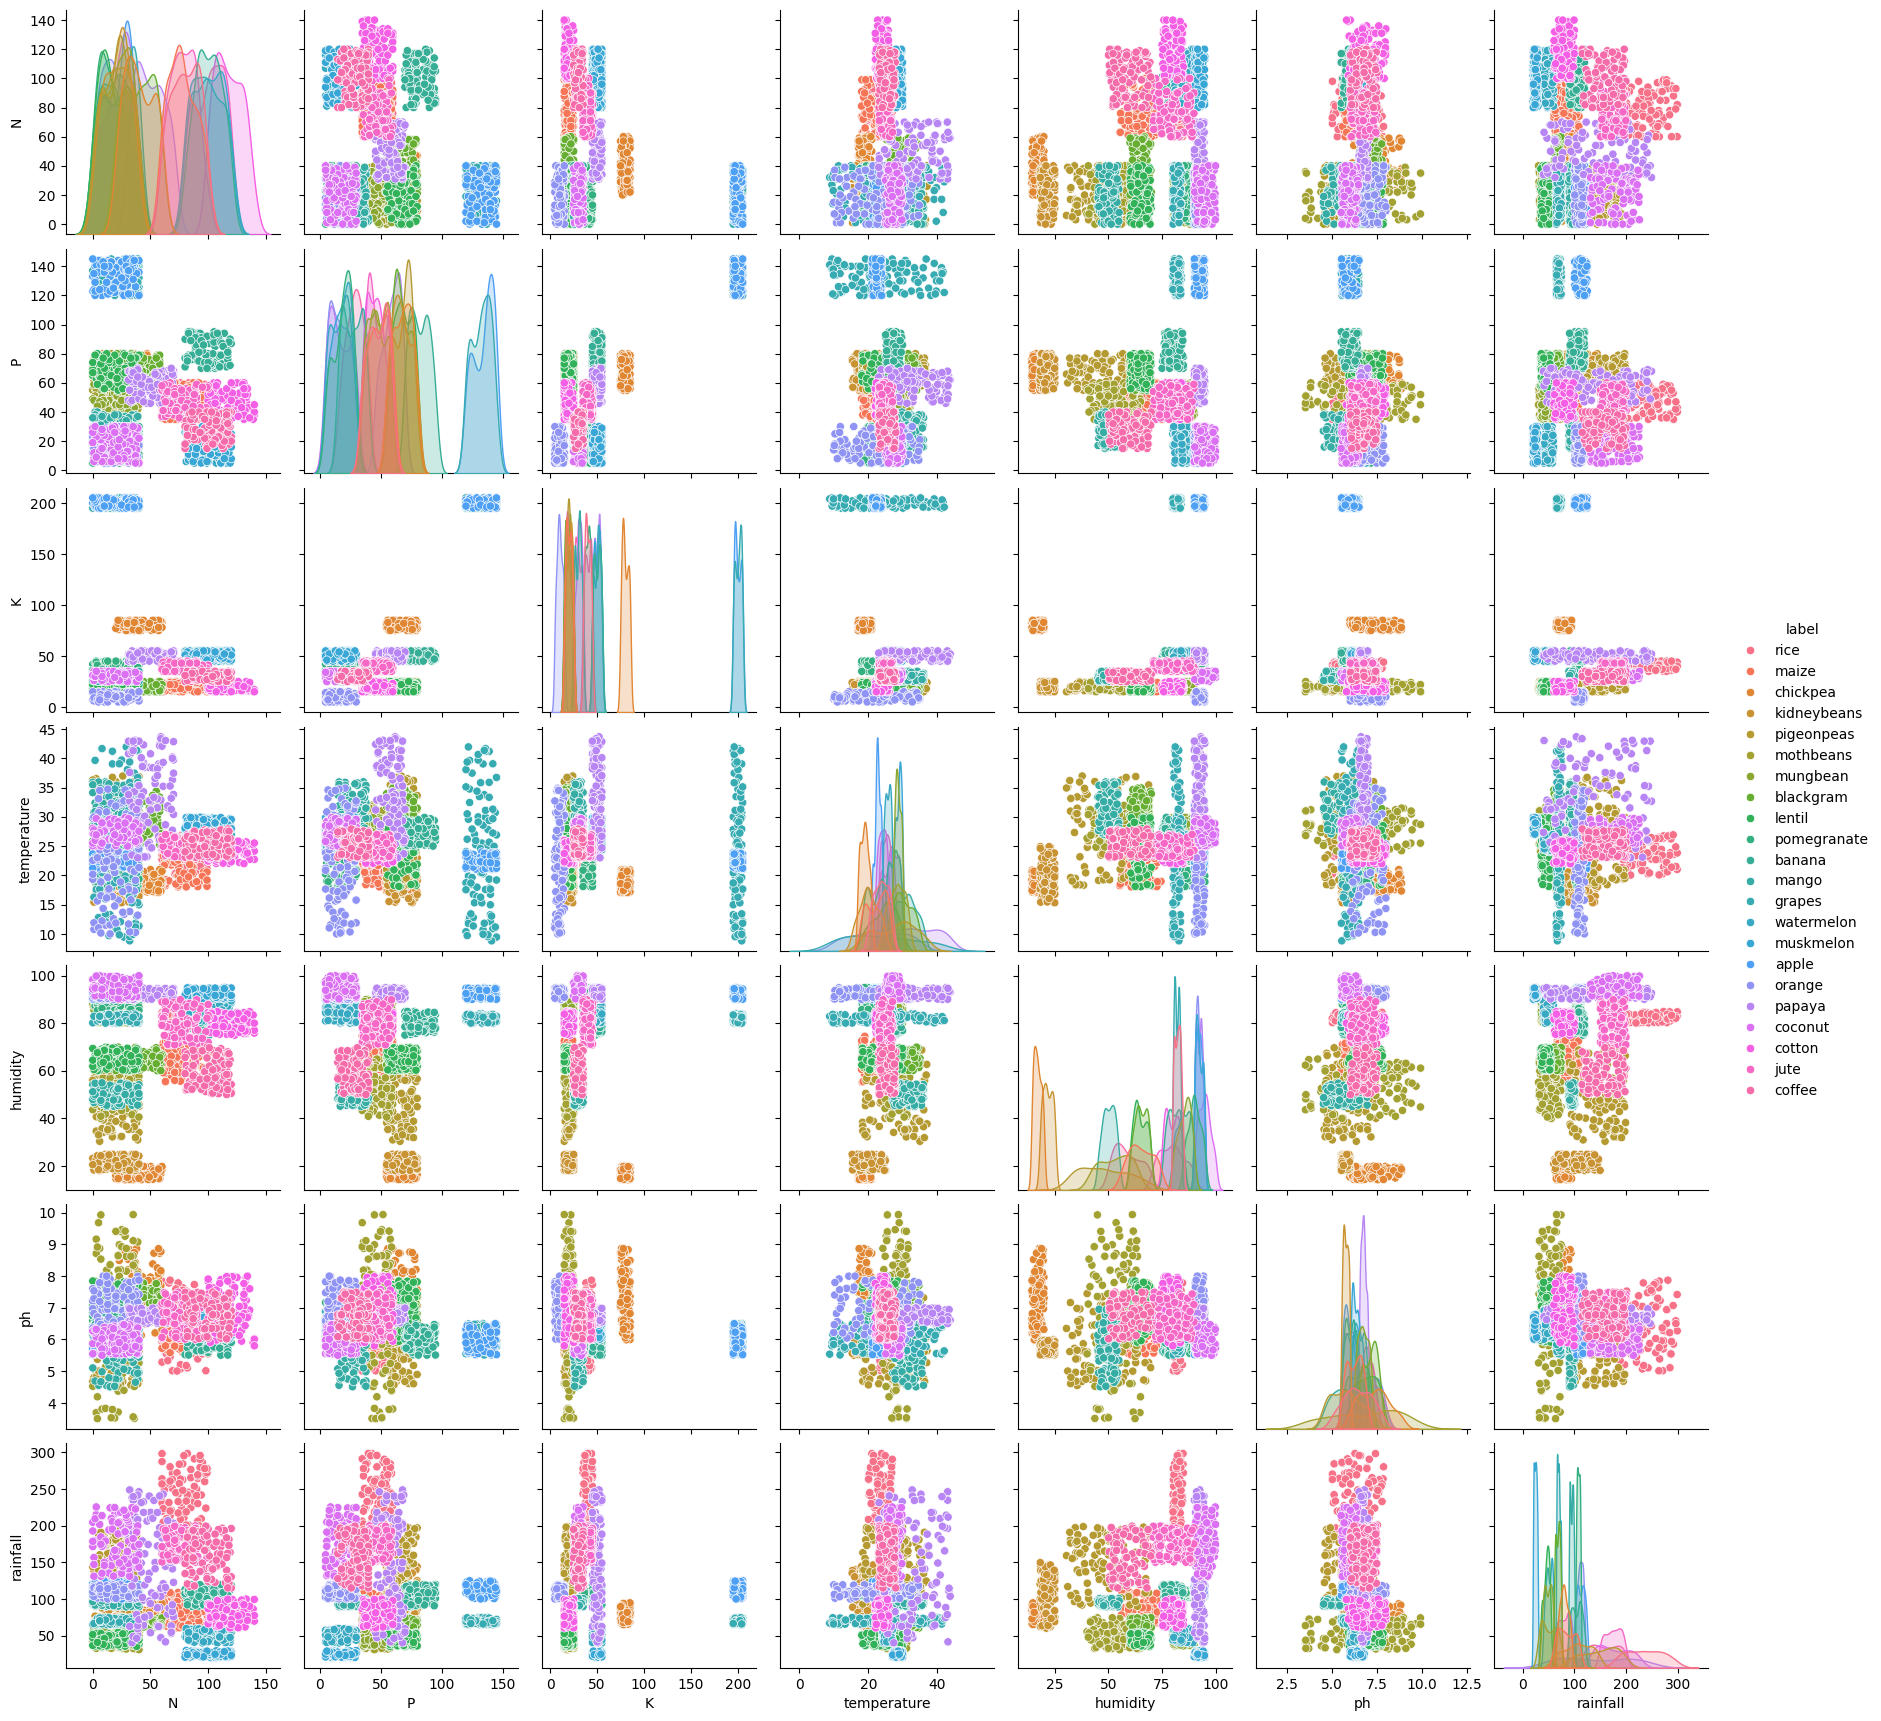

In [7]:
sns.pairplot(df, hue = 'label')

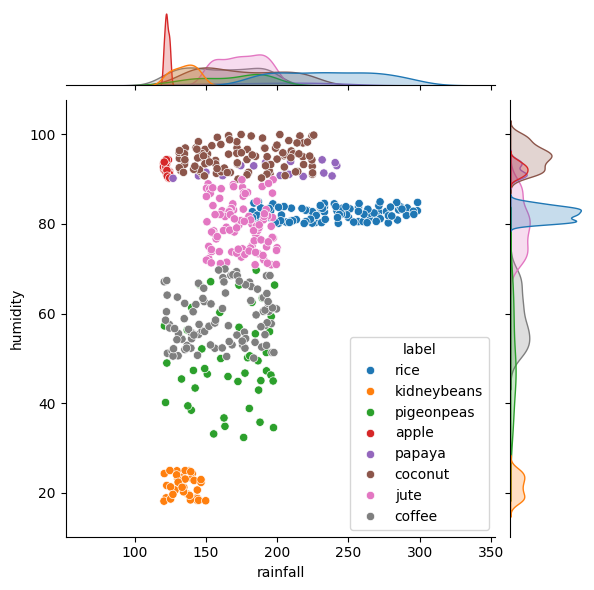

In [8]:
sns.jointplot(x="rainfall",y="humidity",data=df[(df['temperature']<30) & (df['rainfall']>120)],hue="label")

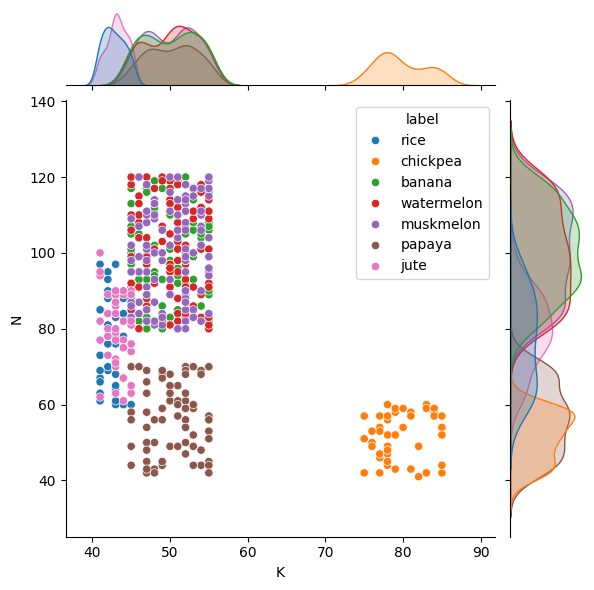

In [9]:
sns.jointplot(x="K",y="N",data=df[(df['N']>40)&(df['K']>40)],hue="label")

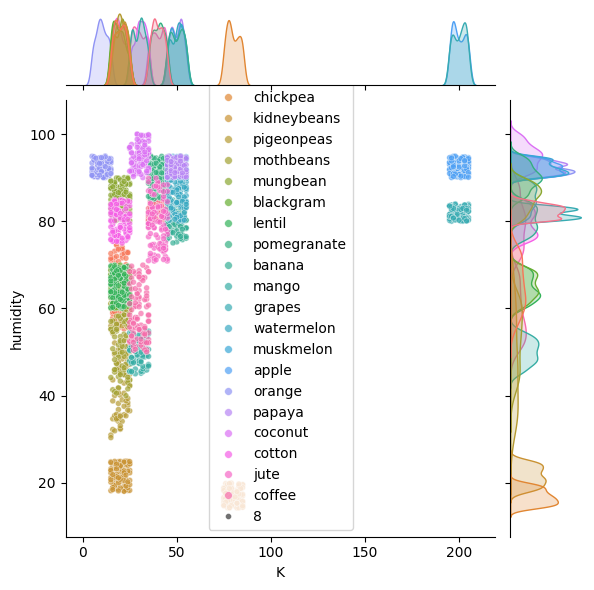

In [10]:
sns.jointplot(x="K",y="humidity",data=df,hue='label',size=8,s=30,alpha=0.7)

<Axes: xlabel='ph', ylabel='label'>

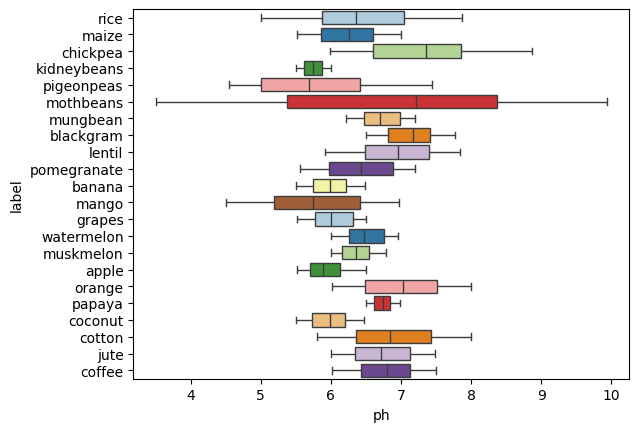

In [11]:
sns.boxplot(y='label', x='ph', data=df, palette="Paired")

<Axes: xlabel='P', ylabel='label'>

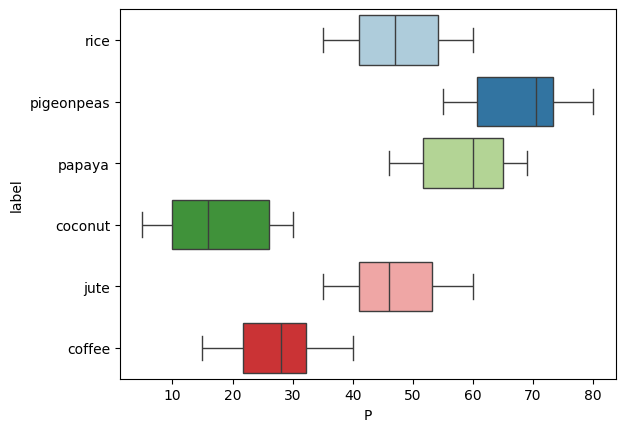

In [12]:
sns.boxplot(y='label',x='P',data=df[df['rainfall']>150], palette="Paired")

<Axes: xlabel='K', ylabel='rainfall'>

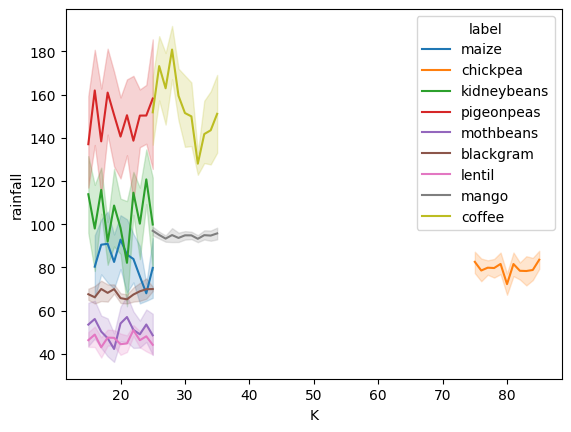

In [13]:
sns.lineplot(data = df[(df['humidity']<65)], x = "K", y = "rainfall",hue="label")

**DATA PRE-PROCESSING**

In [14]:
c=df.label.astype('category')
targets = dict(enumerate(c.cat.categories))
df['target']=c.cat.codes

y=df.target
X=df[['N','P','K','temperature','humidity','ph','rainfall']]

In [15]:
targets

{0: 'apple',
 1: 'banana',
 2: 'blackgram',
 3: 'chickpea',
 4: 'coconut',
 5: 'coffee',
 6: 'cotton',
 7: 'grapes',
 8: 'jute',
 9: 'kidneybeans',
 10: 'lentil',
 11: 'maize',
 12: 'mango',
 13: 'mothbeans',
 14: 'mungbean',
 15: 'muskmelon',
 16: 'orange',
 17: 'papaya',
 18: 'pigeonpeas',
 19: 'pomegranate',
 20: 'rice',
 21: 'watermelon'}

<Axes: >

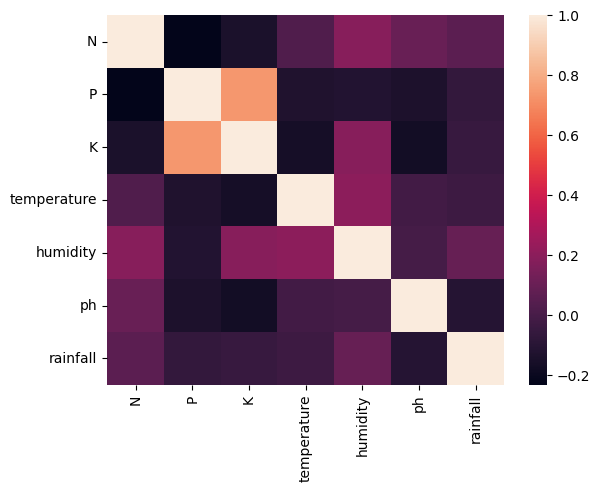

In [16]:
sns.heatmap(X.corr())

**FEATURE SCALING**


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

**MODEL SELECTION**

***KNN Classifier***

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
print('KNN accuracy:{:.2f}%'.format(knn.score(X_test_scaled,y_test)*100))

KNN accuracy:97.82%


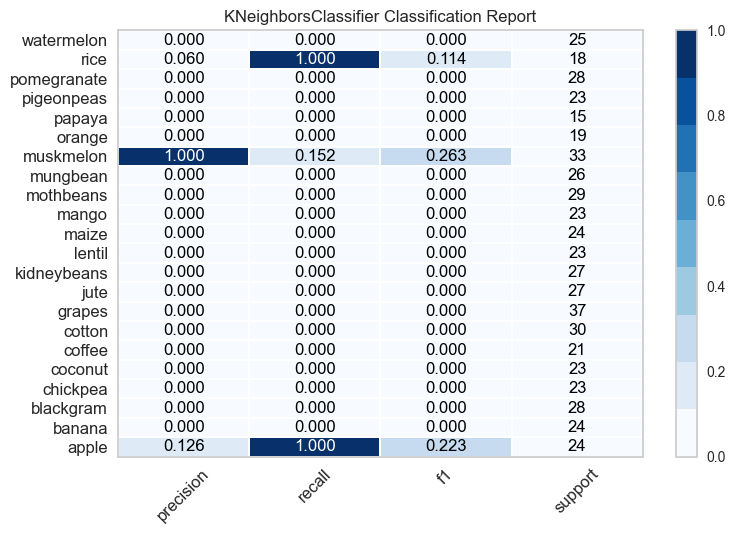

<Axes: title={'center': 'KNeighborsClassifier Classification Report'}>

In [19]:
from yellowbrick.classifier import ClassificationReport
classes=list(targets.values())
visualizer = ClassificationReport(knn, classes=classes, support=True,cmap="Blues")

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

<Axes: >

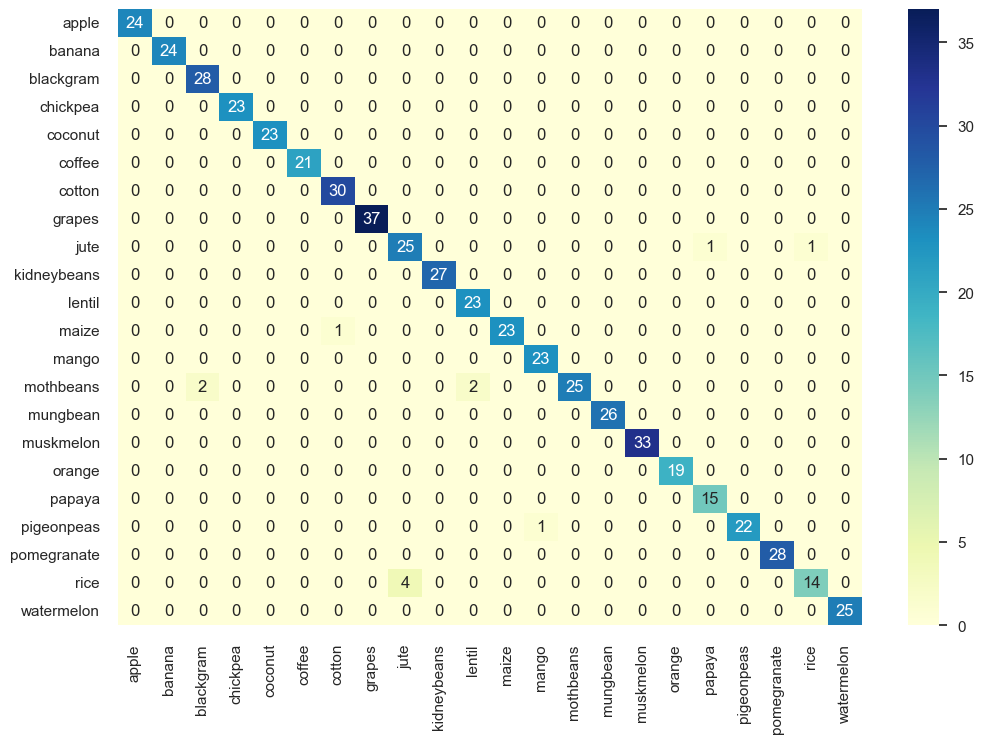

In [20]:
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test,knn.predict(X_test_scaled))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="YlGnBu")

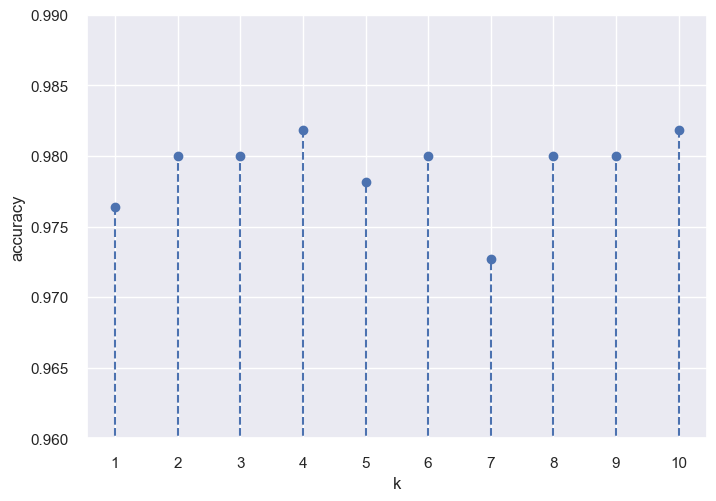

In [21]:
k_range = range(1,11)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.vlines(k_range,0, scores, linestyle="dashed")
plt.ylim(0.96,0.99)
plt.xticks([i for i in range(1,11)]);

***Support Vector Classifer (SVC)***

In [22]:
from sklearn.svm import SVC

svc_linear = SVC(kernel = 'linear').fit(X_train_scaled, y_train)
print("Linear Kernel Accuracy:{: .2f}%".format(svc_linear.score(X_test_scaled,y_test)*100))

svc_rbf = SVC(kernel = 'rbf').fit(X_train_scaled, y_train)
print("Rbf Kernel Accuracy:{: .2f}%".format(svc_rbf.score(X_test_scaled,y_test)*100))

svc_poly = SVC(kernel = 'poly').fit(X_train_scaled, y_train)
print("Poly Kernel Accuracy:{: .2f}%".format(svc_poly.score(X_test_scaled,y_test)*100))

Linear Kernel Accuracy: 97.45%
Rbf Kernel Accuracy: 98.73%
Poly Kernel Accuracy: 98.91%


In [23]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

parameters = {'C': np.logspace(-3, 2, 6).tolist(), 'gamma': np.logspace(-3, 2, 6).tolist()}
# 'degree': np.arange(0,5,1).tolist(), 'kernel':['linear','rbf','poly']

model = GridSearchCV(estimator = SVC(kernel="linear"), param_grid=parameters, n_jobs=-1, cv=4)
model.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})

In [24]:
print("{: .2f}%".format((model.best_score_)*100))
print(model.best_params_ )

 98.67%
{'C': 1.0, 'gamma': 0.001}


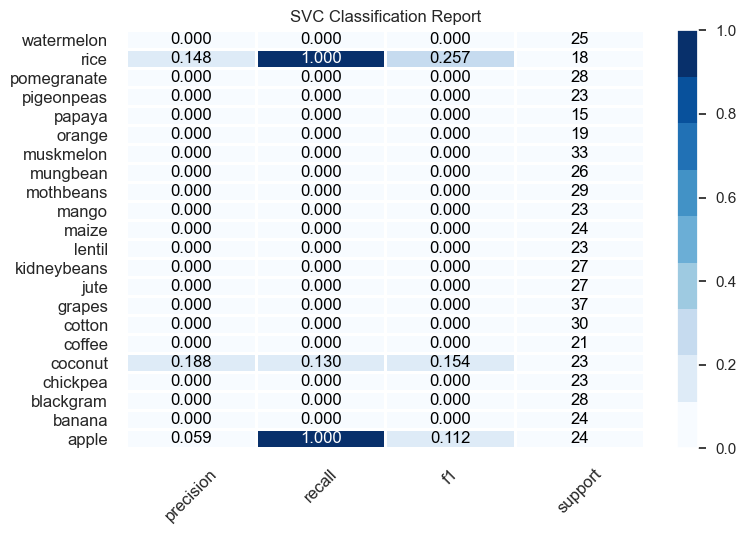

<Axes: title={'center': 'SVC Classification Report'}>

In [25]:
from yellowbrick.classifier import ClassificationReport
classes=list(targets.values())
visualizer = ClassificationReport(svc_poly, classes=classes, support=True,cmap="Blues")

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

<Axes: >

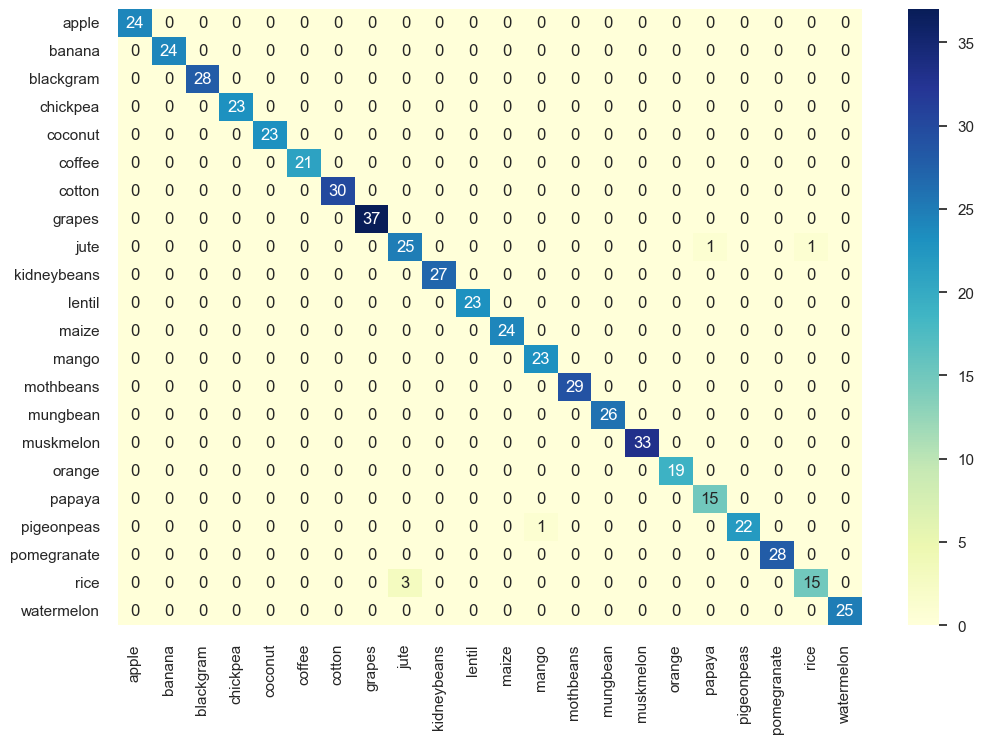

In [26]:
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test,svc_poly.predict(X_test_scaled))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="YlGnBu")

***Decision Tree Classifier***

In [27]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
print('Decision Tree Accuracy on training set: {:.2f}%'.format(dt.score(X_train, y_train)*100))
print('Decision Tree accuracy on testing set:{:.2f}%'.format(dt.score(X_test,y_test)*100))

Decision Tree Accuracy on training set: 100.00%
Decision Tree accuracy on testing set:98.73%


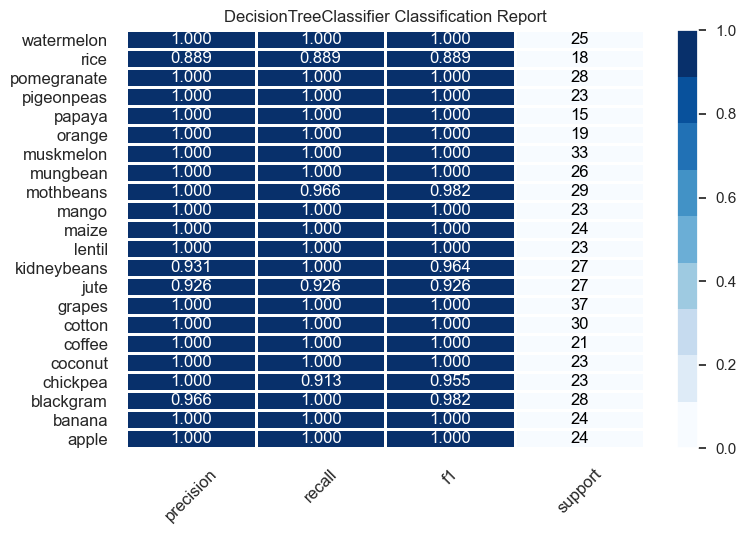

<Axes: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [28]:
from yellowbrick.classifier import ClassificationReport
classes=list(targets.values())
visualizer = ClassificationReport(dt, classes=classes, support=True,cmap="Blues")

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

<Axes: >

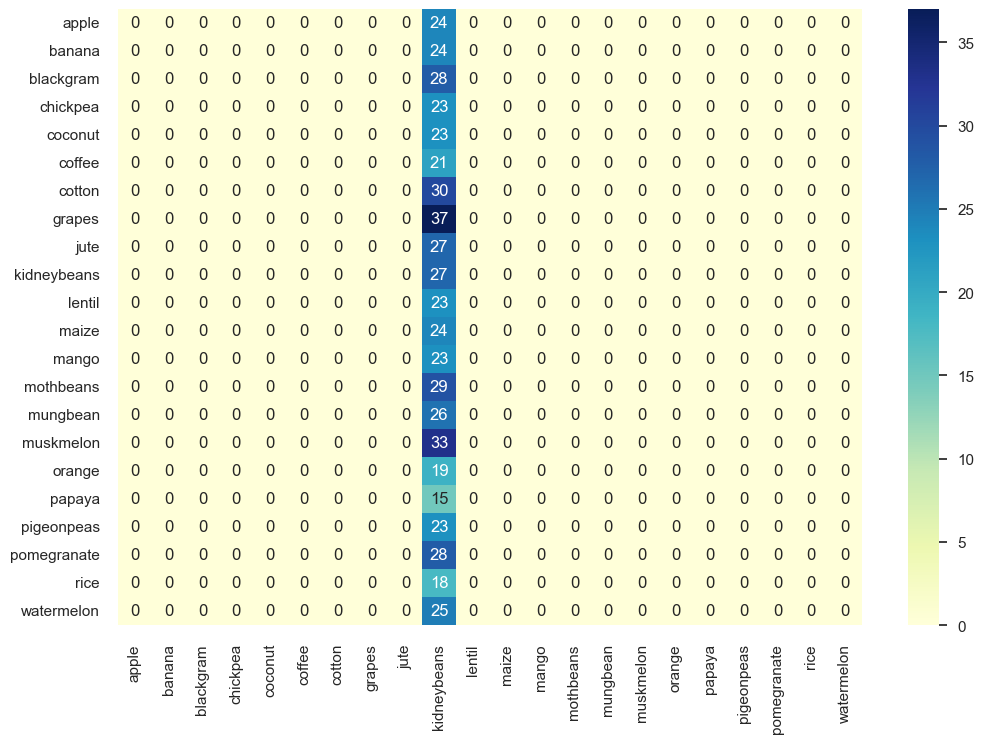

In [29]:
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test,dt.predict(X_test_scaled))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="YlGnBu")

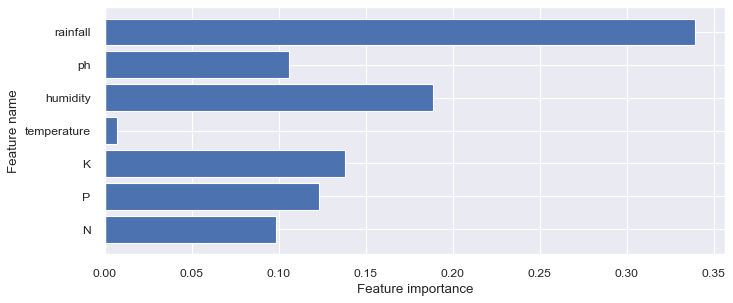

In [30]:
plt.figure(figsize=(10,4), dpi=80)
c_features = len(X_train.columns)
plt.barh(range(c_features), dt.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train.columns)
plt.show()

***Random Forest Classifier***

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=4,n_estimators=100,random_state=42).fit(X_train, y_train)

print('RF Accuracy on training set: {:.2f}%'.format(rf.score(X_train, y_train)*100))
print('RF Accuracy on test set: {:.2f}%'.format(rf.score(X_test, y_test)*100))

RF Accuracy on training set: 97.15%
RF Accuracy on test set: 97.27%


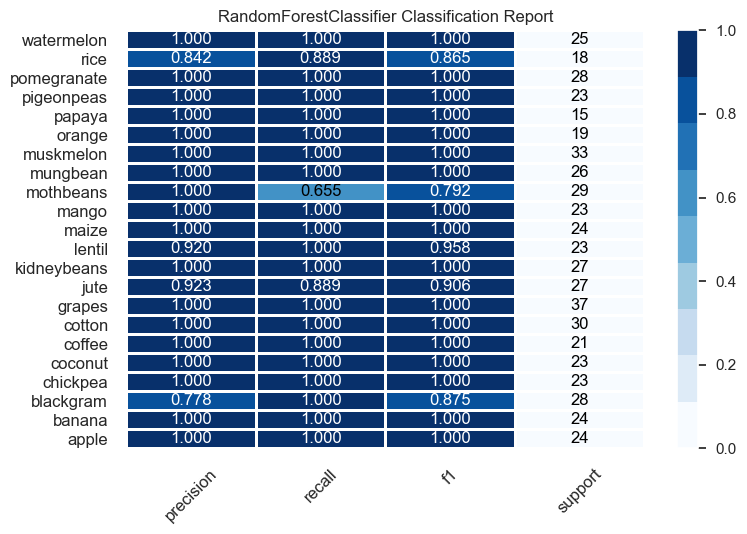

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [32]:
from yellowbrick.classifier import ClassificationReport
classes=list(targets.values())
visualizer = ClassificationReport(rf, classes=classes, support=True,cmap="Blues")

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

<Axes: >

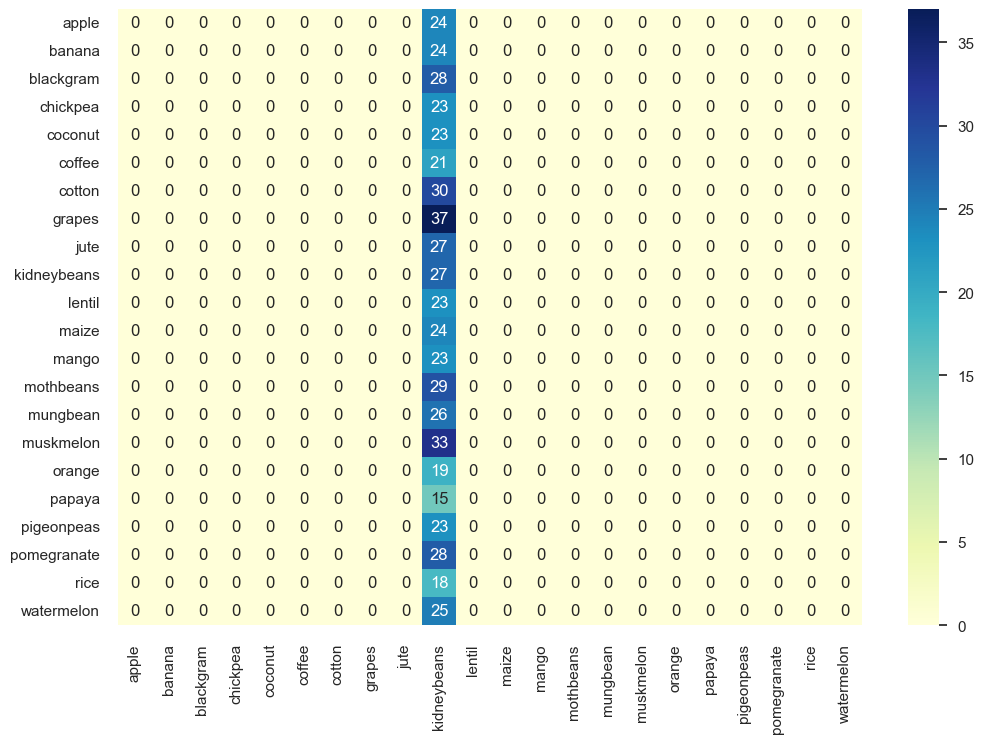

In [33]:
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test,rf.predict(X_test_scaled))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="YlGnBu")

**Gradient Boost**

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier().fit(X_train, y_train)
print('Gradient Boosting accuracy on training set: {:.2f}%'.format(gb.score(X_train, y_train)*100))
print('Gradient Boosting accuracy on testing set: {:.2f}%'.format(gb.score(X_test,y_test)*100))

Gradient Boosting accuracy on training set: 100.00%
Gradient Boosting accuracy on testing set: 99.45%


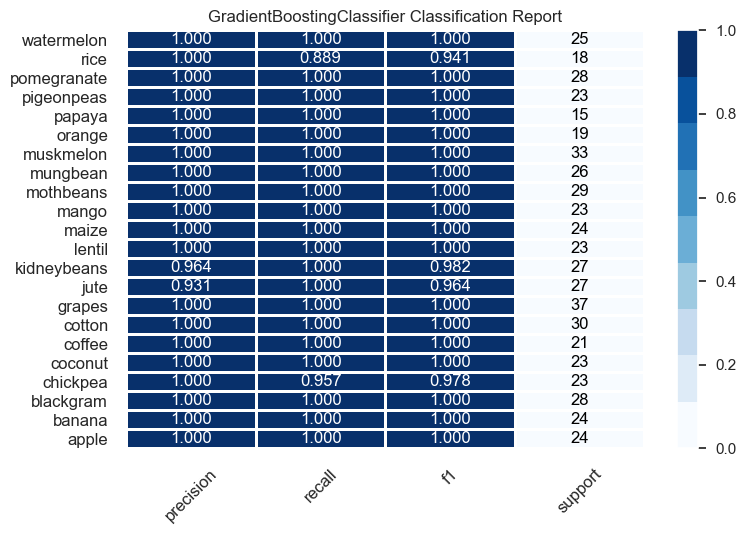

<Axes: title={'center': 'GradientBoostingClassifier Classification Report'}>

In [35]:
from yellowbrick.classifier import ClassificationReport
classes=list(targets.values())
visualizer = ClassificationReport(gb, classes=classes, support=True,cmap="Blues")

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

<Axes: >

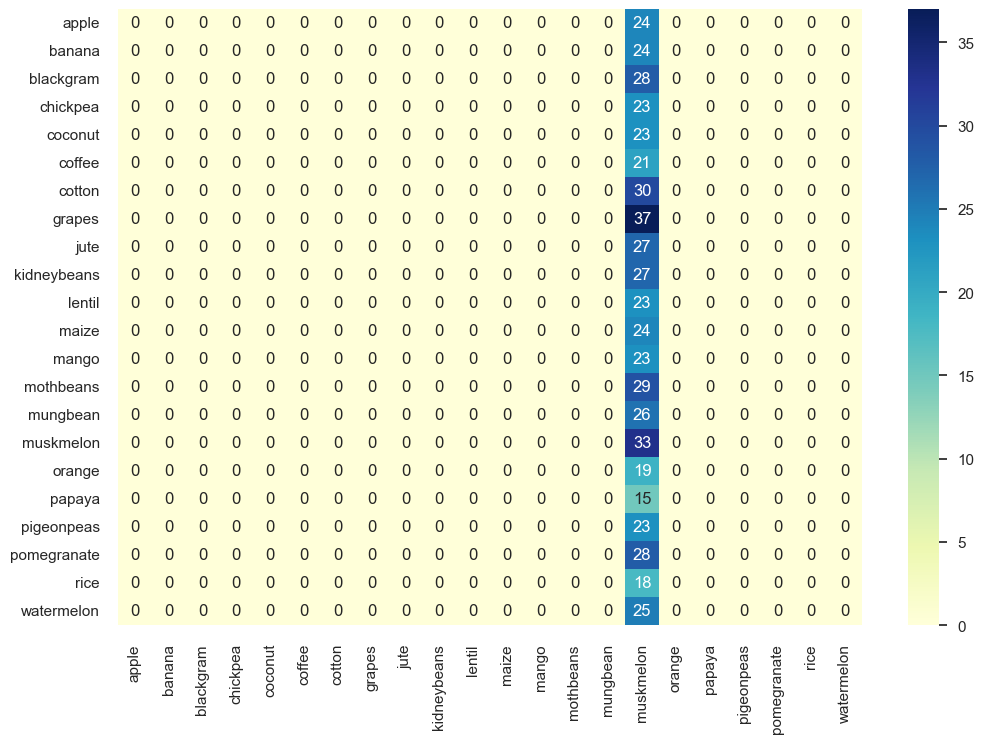

In [36]:
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test,gb.predict(X_test_scaled))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0) # for label size
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="YlGnBu")

**Comparison Table**

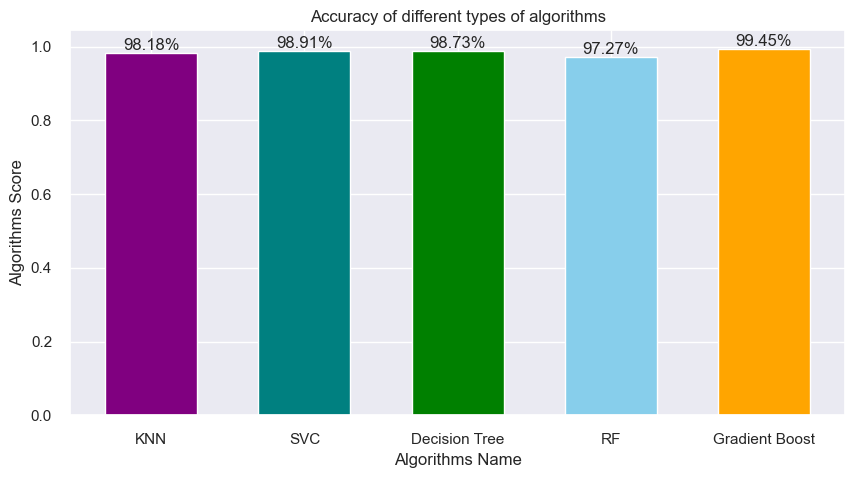

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# Data dictionary with algorithm names and their scores
data = {
    'KNN': knn.score(X_test_scaled, y_test),
    'SVC': svc_poly.score(X_test_scaled, y_test),
    'Decision Tree': dt.score(X_test, y_test),
    'RF': rf.score(X_test, y_test),
    'Gradient Boost': gb.score(X_test, y_test)
}

# Extracting algorithm names and scores
Algorithm_name = list(data.keys())
Algorithm_score = list(data.values())
colors = ["purple", "teal", "green", "skyblue", "orange"]

# Create the bar plot
p = plt.bar(Algorithm_name, Algorithm_score, color=colors, width=0.6)

# Add percentage labels on top of each bar
for bar in p:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position of the text
        height,  # y position of the text (on top of the bar)
        f'{height:.2%}',  # Format the score as a percentage with 2 decimal places
        ha='center',  # horizontal alignment
        va='bottom'  # vertical alignment
    )

# Add labels and title
plt.xlabel("Algorithms Name")
plt.ylabel("Algorithms Score")
plt.title("Accuracy of different types of algorithms")

# Show the plot
plt.show()


**Evaluation**

In [38]:
# Mapping prediction output to crop names
crop_mapping = {
    0: 'apple',
    1: 'banana',
    2: 'blackgram',
    3: 'chickpea',
    4: 'coconut',
    5: 'coffee',
    6: 'cotton',
    7: 'grapes',
    8: 'jute',
    9: 'kidneybeans',
    10: 'lentil',
    11: 'maize',
    12: 'mango',
    13: 'mothbeans',
    14: 'mungbean',
    15: 'muskmelon',
    16: 'orange',
    17: 'papaya',
    18: 'pigeonpeas',
    19: 'pomegranate',
    20: 'rice',
    21: 'watermelon'
}
input_data = [[40, 72, 43, 40.8, 42.0, 8.5, 102.9]]
pred_crop = gb.predict(input_data)

# Printing the result
print(f'Recommended Crop is: {crop_mapping.get(pred_crop[0], "Unknown")}')


Recommended Crop is: papaya


In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import pickle


# Evaluate the model on the training and testing sets
train_accuracy = gb.score(X_train, y_train)
test_accuracy = gb.score(X_test, y_test)

print(f'Gradient Boosting accuracy on training set: {train_accuracy * 100:.2f}%')
print(f'Gradient Boosting accuracy on testing set: {test_accuracy * 100:.2f}%')

# Save the trained model to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(gb, f)

print("Model saved as 'model.pkl'")


Gradient Boosting accuracy on training set: 100.00%
Gradient Boosting accuracy on testing set: 99.45%
Model saved as 'model.pkl'
